In [10]:
# Imports

import pandas as pd
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.cluster import KMeans
from PIL import Image
import imagehash
import os
import logging

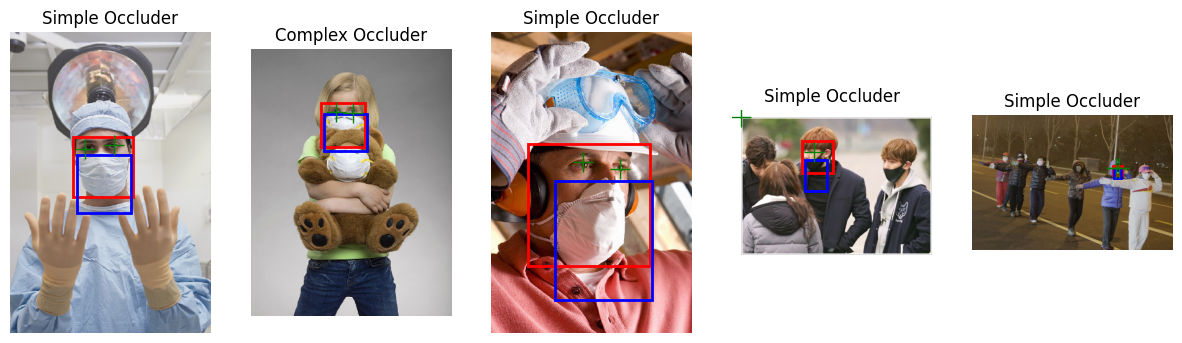

In [11]:
# MAFA Dataset Exploration / Visualization

# Load the .mat file
train_data = scipy.io.loadmat(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\LabelTrainAll.mat')

# Convert the data to a DataFrame
df = pd.DataFrame(train_data['label_train'][0])
df

# Define the path to the images
train_image_path = r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images'

# Function to display image with bounding boxes and eye positions
def display_image_with_features(row):
    # Load th image
    img_name = row['imgName'][0]
    image = plt.imread(train_image_path + '\\' + img_name)
    
    # Display the image
    plt.imshow(image)
    
    # Get the face bounding box
    face_bbox = row['label'][0][:4]
    x, y, w, h = face_bbox
    
    # Draw face bounding box
    plt.gca().add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
    
    # Get the bounding box of the occluder
    occluder_bbox = row['label'][0][8:12]
    if not np.all(occluder_bbox == -1):
        ox, oy, ow, oh = occluder_bbox
        # Draw occluder bounding box
        plt.gca().add_patch(patches.Rectangle((x + ox, y + oy), ow, oh, linewidth=2, edgecolor='b', facecolor='none'))
    
    # Get the bounding box of the glasses
    glasses_bbox = row['label'][0][-4:]
    if not np.all(glasses_bbox == -1):
        gx, gy, gw, gh = glasses_bbox
        # Draw glasses bounding box
        plt.gca().add_patch(patches.Rectangle((x + gx, y + gy), gw, gh, linewidth=2, edgecolor='g', facecolor='none'))
    
    # Get the positions of the eyes (relative to the face bounding box)
    eye1_x, eye1_y, eye2_x, eye2_y = row['label'][0][4:8]
    
    # Draw crosses for the positions of the eyes
    plt.plot(eye1_x, eye1_y, 'g+', markersize=15)  # Green cross for eye 1
    plt.plot(eye2_x, eye2_y, 'g+', markersize=15)  # Green cross for eye 2
    
    # Determine whether the person is wearing a mask or not
    occ_type = row['label'][0][12]
    # plt.title('Mask' if occ_type == 1 else f'No Mask - {occ_type}')
    plt.title('Simple Occluder' if occ_type == 1 else 'Complex Occluder' if occ_type == 2 else 'Human Body' if occ_type == 3 else 'Unknown Occluder Type')

    # Additional information below the image
    additional_info = """Face Bounding Box (x, y, w, h): {}\nEye Positions (x1, y1), (x2, y2): ({}, {}), ({}, {})\nOccluder Bounding Box (x, y, w, h): {}\nOcc Type: {}\nOcc Degree: {}\nGender: {}\nRace: {}\nOrientation: {}\nGlasses Bounding Box (x, y, w, h): {}\n""".format(
        (x, y, w, h),
        eye1_x, eye1_y, eye2_x, eye2_y,
        occluder_bbox,
        row['label'][0][11],
        row['label'][0][13],
        row['label'][0][14],
        row['label'][0][15],
        row['label'][0][16],
        row['label'][0][-4:]
    )

    # plt.text(0, 0, additional_info, fontsize=10, ha='left', va='top')

def show_random_faces():
    plt.figure(figsize=(15, 10))
    for i in range(5):
        random_idx = np.random.randint(len(df))  # Randomly select an index
        row = df.iloc[random_idx].copy()  # Get a copy of the row
        plt.subplot(5, 5, i+1)
        display_image_with_features(row)
        plt.axis('off')

    plt.show()
    
def show_selected_faces(rows):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(rows, start=1):
        row = df.iloc[idx].copy()
        plt.subplot(1, 5, i)
        display_image_with_features(row)
        plt.axis('off')
        
    plt.show()

rows = [0, 1, 2, 27, 28]
show_selected_faces(rows)


In [12]:
# Correctly structures both training data and the test data into their own csvs

import scipy.io
import pandas as pd

# Load the .mat files
test_data = scipy.io.loadmat(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Test\LabelTestAll.mat')
train_data = scipy.io.loadmat(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\LabelTrainAll.mat')

# Convert the test data to a DataFrame
test_label_data = test_data['LabelTest'][0]
test_rows = []
for img_name, label_array in test_label_data:
    img_name = img_name[0]
    for label in label_array:
        row = [img_name] + label.tolist()
        test_rows.append(row)

# Create a DataFrame for test data
test_df = pd.DataFrame(test_rows, columns=['imgName', 'face_x', 'face_y', 'face_w', 'face_h', 'face_type', 'occluder_x', 'occluder_y', 'occluder_w', 'occluder_h', 'occluder_type', 'occluder_degree', 'gender', 'race', 'orientation', 'glasses_x', 'glasses_y', 'glasses_w', 'glasses_h'])

# Convert the bounding box coordinates from strings to floats for test data
for col in test_df.columns[1:]:
    test_df[col] = test_df[col].astype(float)

# Save the test DataFrame to a CSV file
test_df.to_csv('csv/MAFA_test_data.csv', index=False)
print("Test CSV file has been successfully generated.")

# Convert the training data to a DataFrame
train_label_data = train_data['label_train'][0]
train_rows = []
for item in train_label_data:
    org_img_name = item[0]
    img_name = item[1]
    label_array = item[2]
    for label in label_array:
        row = [img_name[0]] + label.tolist()
        train_rows.append(row)

# Create a DataFrame for training data
train_df = pd.DataFrame(train_rows, columns=['imgName', 'face_x', 'face_y', 'face_w', 'face_h', 'eye1_x', 'eye1_y', 'eye2_x', 'eye2_y', 'occluder_x', 'occluder_y', 'occluder_w', 'occluder_h', 'occluder_type', 'occluder_degree', 'gender', 'race', 'orientation', 'glasses_x', 'glasses_y', 'glasses_w', 'glasses_h'])

# Convert the bounding box coordinates from strings to floats for training data
for col in train_df.columns[1:]:
    train_df[col] = train_df[col].astype(float)

# Save the training DataFrame to a CSV file
train_df.to_csv('csv/MAFA_training_data.csv', index=False)
print("Training CSV file has been successfully generated.")

Test CSV file has been successfully generated.
Training CSV file has been successfully generated.


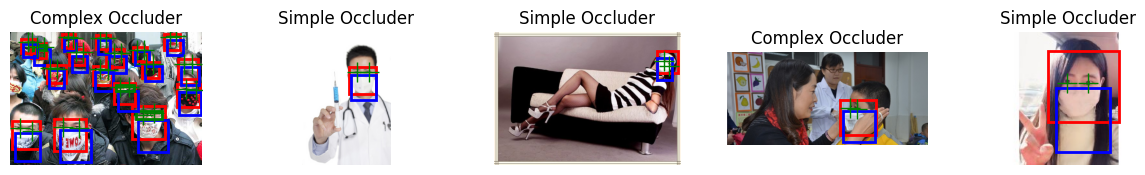

In [13]:
# MAFA Dataset Exploration / Visualization for multiple faces in the same image

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Load the data from the CSV files
train_df = pd.read_csv('csv/MAFA_training_data.csv')

# Define the path to the images
image_path = r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images'

# Function to display image with bounding boxes and eye positions
def display_image_with_features(rows):
    # Load the image
    img_name = rows.iloc[0]['imgName']
    image = plt.imread(image_path + '/' + img_name)
    
    # Display the image
    plt.imshow(image)
    
    # Plot each face assigned to the same image
    for index, row in rows.iterrows():
        face_bbox = row[['face_x', 'face_y', 'face_w', 'face_h']].values
        x, y, w, h = face_bbox
        
        # Draw face bounding box
        plt.gca().add_patch(patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'))
        
        # Get the bounding box of the occluder
        occluder_bbox = row[['occluder_x', 'occluder_y', 'occluder_w', 'occluder_h']].values
        if not np.all(occluder_bbox == -1):
            ox, oy, ow, oh = occluder_bbox
            # Draw occluder bounding box
            plt.gca().add_patch(patches.Rectangle((x + ox, y + oy), ow, oh, linewidth=2, edgecolor='b', facecolor='none'))
        
        # Get the bounding box of the glasses
        glasses_bbox = row[['glasses_x', 'glasses_y', 'glasses_w', 'glasses_h']].values
        if not np.all(glasses_bbox == -1):
            gx, gy, gw, gh = glasses_bbox
            # Draw glasses bounding box
            plt.gca().add_patch(patches.Rectangle((x + gx, y + gy), gw, gh, linewidth=2, edgecolor='g', facecolor='none'))
        
        # Get the positions of the eyes (relative to the face bounding box)
        eye1_x, eye1_y, eye2_x, eye2_y = row[['eye1_x', 'eye1_y', 'eye2_x', 'eye2_y']].values
        
        # Draw crosses for the positions of the eyes
        plt.plot(eye1_x, eye1_y, 'g+', markersize=15)  # Green cross for eye 1
        plt.plot(eye2_x, eye2_y, 'g+', markersize=15)  # Green cross for eye 2
        
        # Determine the occluder type
        occ_type = row['occluder_type']
        occluder_type = 'Simple Occluder' if occ_type == 1 else 'Complex Occluder' if occ_type == 2 else 'Human Body' if occ_type == 3 else 'Unknown Occluder Type'
        plt.title(occluder_type)

# Function to show random faces
def show_random_faces():
    plt.figure(figsize=(15, 10))
    for i in range(5):
        random_idx = np.random.randint(len(train_df))  # Randomly select an index
        img_name = train_df.iloc[random_idx]['imgName']
        rows = train_df[train_df['imgName'] == img_name]
        plt.subplot(5, 5, i+1)
        display_image_with_features(rows)
        plt.axis('off')

    plt.show()

# Function to show selected faces
def show_selected_faces(rows):
    plt.figure(figsize=(15, 10))
    for i, idx in enumerate(rows, start=1):
        img_name = train_df.iloc[idx]['imgName']
        rows_for_image = train_df[train_df['imgName'] == img_name]
        plt.subplot(1, 5, i)
        display_image_with_features(rows_for_image)
        plt.axis('off')

    plt.show()

rows = [0, 1, 2, 27, 29]  # Example list of row indices
# show_selected_faces(rows)
show_random_faces()


In [14]:
# Clean the data...ensuring that there are no duplicates, missing values...

df = pd.read_csv('csv/MAFA_Training_Data_Unstructured.csv')

### Missing Value validation

# Identify missing values
missing_values = df.isnull().sum()
print("Missing Values:")
print(missing_values)

# Fill in the missing values with the mean value.
# df.fillna(df.mean(), inplace=True) # Cannot be done with images, thus we just remove the row completely.
df.dropna(inplace=True)

### Validating that each of the columns has a value attached to it

### Double checking for duplicate values - Does nothing with them, just a note at the moment.

logging.basicConfig(filename='logs\duplicate_images.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def find_duplicate_images(image_dir):
    """
    Find duplicate images in a directory based on their perceptual hashes and log them.
    """
    # Dictionary to store hashes and corresponding filenames
    hash_dict = {}
    
    # List to store duplicate image filenames
    duplicate_images = []
    
    # Iterate through all files in the directory
    for filename in os.listdir(image_dir):
        # Check if the file is an image
        if filename.endswith((".jpg", ".png")):
            # Get the full file path
            filepath = os.path.join(image_dir, filename)
            
            # Open the image and calculate its hash
            try:
                with Image.open(filepath) as img:
                    hash_val = str(imagehash.average_hash(img))
            except Exception as e:
                logging.error(f"Error processing image {filename}: {e}")
                continue
            
            # Check if the hash already exists in the dictionary
            if hash_val in hash_dict:
                # Add the current filename and the filename already stored in hash_dict
                duplicate_images.append((filename, hash_dict[hash_val]))
                logging.info(f"Duplicate image found: {filename} is a duplicate of {hash_dict[hash_val]}")
            else:
                # Add the hash and filename to the dictionary
                hash_dict[hash_val] = filename
                
    # Log the results
    if duplicate_images:
        logging.info(f"Total {len(duplicate_images)} duplicate images found.")
    else:
        logging.info("No duplicate images found.")

# Call the function to find and print duplicate images // commented out because i don't want it to happen
# find_duplicate_images(train_image_path)

Missing Values:
orgImgName         0
imgName            0
face_x             0
face_y             0
face_w             0
face_h             0
eye1_x             0
eye1_y             0
eye2_x             0
eye2_y             0
occluder_x         0
occluder_y         0
occluder_w         0
occluder_h         0
occluder_type      0
occluder_degree    0
gender             0
race               0
orientation        0
glasses_x          0
glasses_y          0
glasses_w          0
glasses_h          0
dtype: int64


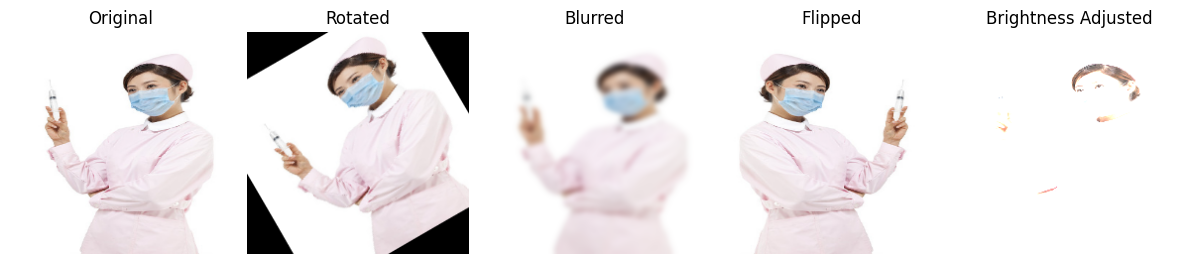

In [15]:
# Basic Augmentation Demonstration - Rotation, Blue, Flipped, and brightness adjustment. No bbx.

import cv2
import numpy as np
import matplotlib.pyplot as plt

def augment_and_plot(row):
    # Load the image
    img_name = row['imgName']
    img = cv2.imread(image_path + '\\' + img_name)
    target_size = (224, 224)
    img = cv2.resize(img, target_size)
    
    # Convert image to RGB for displaying with matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Plot the original image
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 5, 1)
    plt.imshow(img_rgb)
    plt.title('Original')
    plt.axis('off')
    
    # Rotation
    rotation_angle = 30
    rotation_matrix = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), rotation_angle, 1)
    rotated_img = cv2.warpAffine(img, rotation_matrix, (img.shape[1], img.shape[0]))
    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(rotated_img, cv2.COLOR_BGR2RGB))
    plt.title('Rotated')
    plt.axis('off')
    
    # Blur
    blurred_img = cv2.GaussianBlur(img, (15, 15), 0)
    plt.subplot(1, 5, 3)
    plt.imshow(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))
    plt.title('Blurred')
    plt.axis('off')
    
    # Flipping
    flipped_img = cv2.flip(img, 1)  # 1 for horizontal flip
    plt.subplot(1, 5, 4)
    plt.imshow(cv2.cvtColor(flipped_img, cv2.COLOR_BGR2RGB))
    plt.title('Flipped')
    plt.axis('off')
    
    # Brightness adjustmet
    brightness_adjusted_img = cv2.convertScaleAbs(img, alpha=2.0, beta=50)
    plt.subplot(1, 5, 5)
    plt.imshow(cv2.cvtColor(brightness_adjusted_img, cv2.COLOR_BGR2RGB))
    plt.title('Brightness Adjusted')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

row_index = 67  # Choose a specific row for testing
row = df.iloc[row_index]
augment_and_plot(row)


PCA transformation completed and saved as MAFA_Training_data_PCA.csv


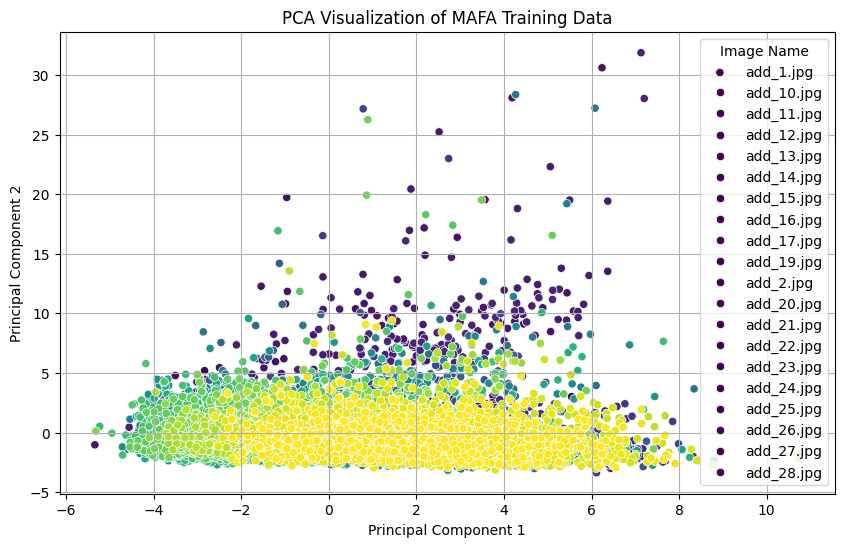

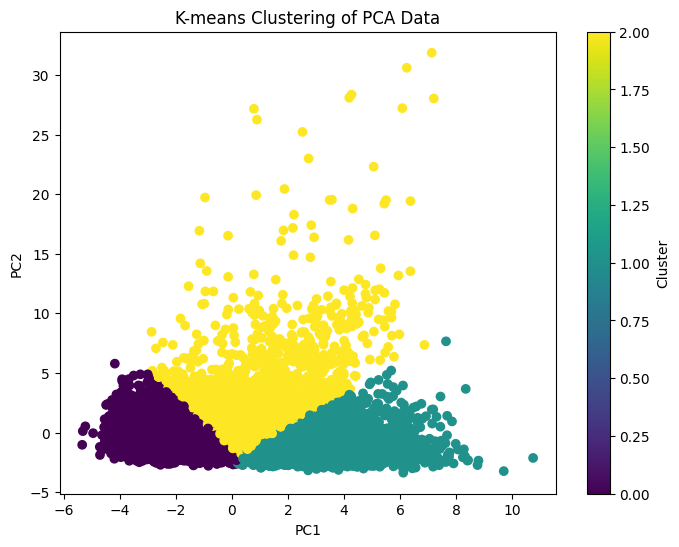

In [16]:
# Best version of the PCA dimensionality reduction algorithm.

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the data from CSV
df = pd.read_csv("csv/MAFA_Training_Data_Unstructured_Resized.csv")

# Select relevant columns for PCA
features = ['face_x', 'face_y', 'face_w', 'face_h', 
            'eye1_x', 'eye1_y', 'eye2_x', 'eye2_y', 
            'occluder_x', 'occluder_y', 'occluder_w', 'occluder_h', 
            'occluder_type', 'occluder_degree', 'gender', 'race', 'orientation',
            'glasses_x', 'glasses_y', 'glasses_w', 'glasses_h']

# Separating out the features
x = df.loc[:, features].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

# Applying PCA
pca = PCA(n_components=2)  # You can adjust the number of components as needed
principalComponents = pca.fit_transform(x)

# Creating a DataFrame for the principal components
principal_df = pd.DataFrame(data=principalComponents, columns=['PC1', 'PC2'])

# Concatenating the principal components DataFrame with the original DataFrame
final_df = pd.concat([df[['orgImgName', 'imgName']], principal_df], axis=1)

# Saving the transformed data to a new CSV file
final_df.to_csv("csv/MAFA_Training_data_PCA.csv", index=False)

print("PCA transformation completed and saved as MAFA_Training_data_PCA.csv")

# Plotting of the PCA results and using K-means...Possibly incorrect PCA results. Not too sure.

# Load the transformed data from the CSV file
df = pd.read_csv('csv/MAFA_Training_data_PCA.csv')

# Limit the number of unique image names for the legend
max_legend_entries = 20
unique_img_names = df['orgImgName'].unique()[:max_legend_entries]

# sampled_df = df.sample(n=2000) # Can be used to select a random sample of size n

# Create a scatter plot with principal components
plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x='PC1', y='PC2', palette='viridis')
sns.scatterplot(data=df, x='PC1', y='PC2', hue='orgImgName', palette='viridis') # Significantly slower to load when applying hue
plt.title('PCA Visualization of MAFA Training Data')
plt.xlabel('Principal Component 1') # Principal Component 1 is the Face BBX
plt.ylabel('Principal Component 2') # Principal Component 1 is the Occluder BBX
plt.legend(title='Image Name', labels=unique_img_names, loc='upper right')
plt.grid(True)
plt.show()

# Assuming df_pca contains the data with PC1 and PC2 columns
# Perform K-means clustering
kmeans = KMeans(n_clusters=3)  # Specify the number of clusters
clusters = kmeans.fit_predict(df[['PC1', 'PC2']])

# Visualize clusters
plt.figure(figsize=(8, 6))
plt.scatter(df['PC1'], df['PC2'], c=clusters, cmap='viridis')
plt.title('K-means Clustering of PCA Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()


Models

C:\Users\alexw\AppData\Local\Temp\ipykernel_51400\110127532.py:80: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(augmented_datagen, epochs=10, validation_data=(X_test, y_test))


Epoch 1/10
369/369 [==============================] - 66s 174ms/step - loss: 0.2812 - accuracy: 0.9247 - val_loss: 0.2667 - val_accuracy: 0.9240
Epoch 2/10
369/369 [==============================] - 59s 159ms/step - loss: 0.2746 - accuracy: 0.9255 - val_loss: 0.2649 - val_accuracy: 0.9240
Epoch 3/10
369/369 [==============================] - 57s 155ms/step - loss: 0.2717 - accuracy: 0.9255 - val_loss: 0.2649 - val_accuracy: 0.9240
Epoch 4/10
369/369 [==============================] - 57s 155ms/step - loss: 0.2701 - accuracy: 0.9255 - val_loss: 0.2758 - val_accuracy: 0.9240
Epoch 5/10
369/369 [==============================] - 56s 151ms/step - loss: 0.2682 - accuracy: 0.9255 - val_loss: 0.2663 - val_accuracy: 0.9240
Epoch 6/10
369/369 [==============================] - 56s 151ms/step - loss: 0.2681 - accuracy: 0.9255 - val_loss: 0.2650 - val_accuracy: 0.9240
Epoch 7/10
369/369 [==============================] - 55s 150ms/step - loss: 0.2669 - accuracy: 0.9255 - val_loss: 0.2649 - val_ac

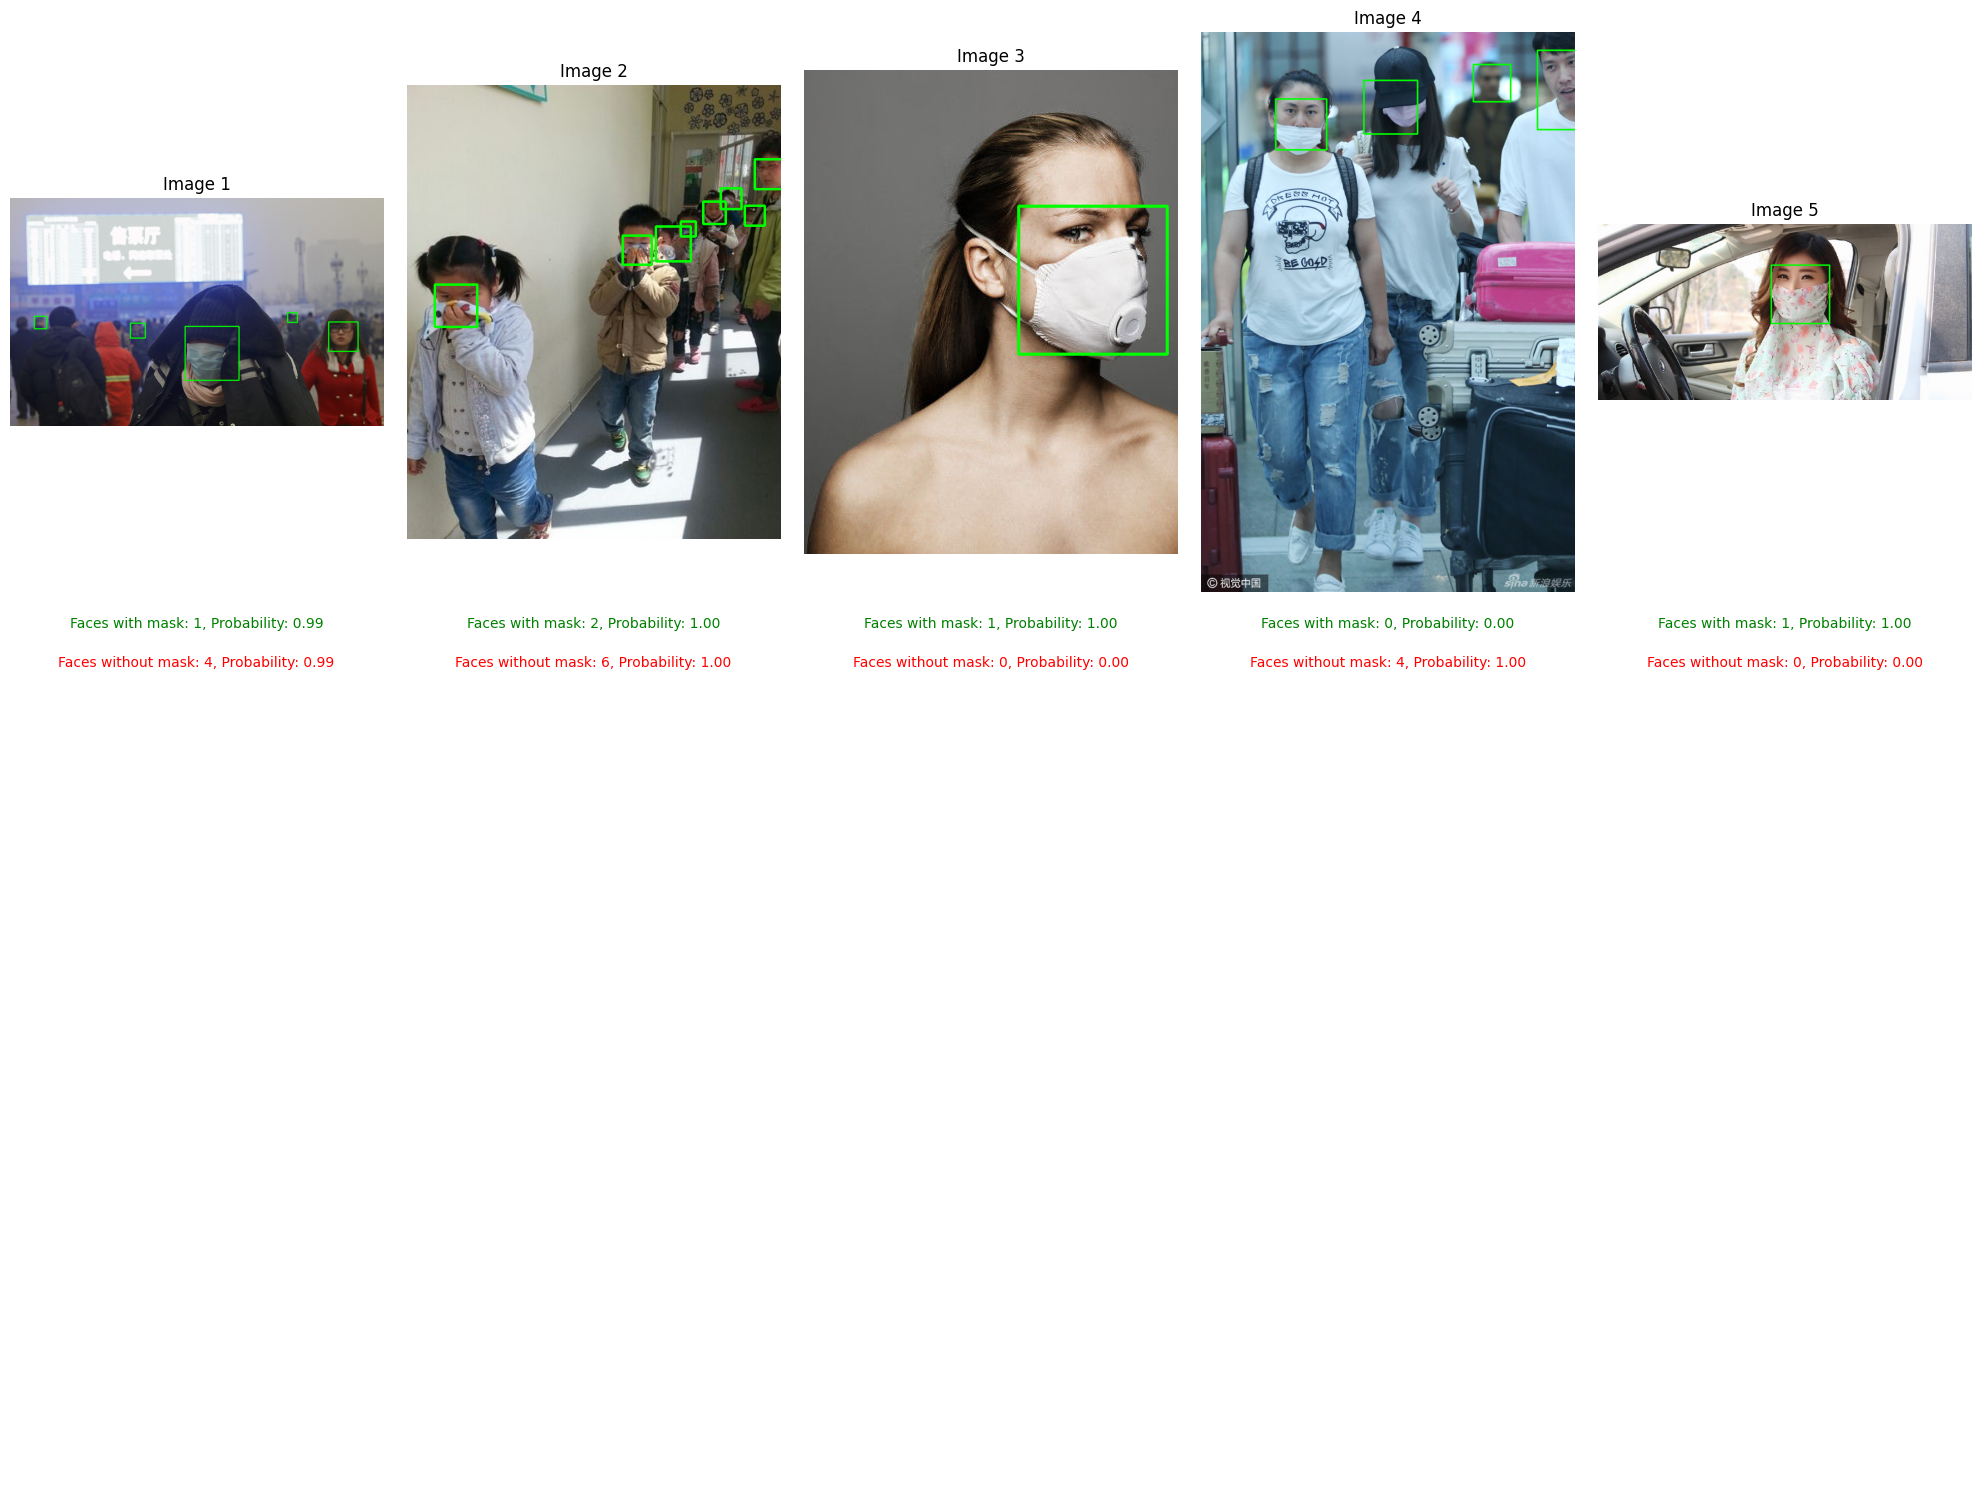

In [17]:
# Custom CNN Model. Undergoes 3 cycles before flattening and a total training of 10 epochs. I noticed a convergence in the accuracy, thus further training would not yield better results. Would need to look at further improvement of data i'd imagine.

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random

image_labels = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_training_data.csv')
path_to_images = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images"

# Add mask_label column - defines whether the occluder in the image is a simple mask, complex mask or whether it is a human bodypart occluding.
image_labels['mask_label'] = np.where((image_labels['occluder_type'] == 1) | (image_labels['occluder_type'] == 2), 1, 0)

# Define image size
img_size = 100

# Load and preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0 # Normalize pixel values
    return img

# Load images and labels
X = np.array([preprocess_image(os.path.join(path_to_images, img_name)) for img_name in image_labels['imgName']])
y = to_categorical(image_labels['mask_label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def random_angle():
    return np.random.uniform(0, 360)  # Random angle between 0 and 360 degrees

def random_percentage():
    return np.random.uniform(0, 1)  # Random percentage between 0 and 1

def random_choice():
    return np.random.choice([True, False])  # Random boolean value

# Define image augmentation parameters using keras
datagen = ImageDataGenerator(
    rotation_range=random_angle(), # Rotate images by a random number degrees
    width_shift_range=random_percentage(), # Shift images horizontally by 10%
    height_shift_range=random_percentage(), # Shift images vertically by 10%
    horizontal_flip=random_choice(), # Randomly flip images horizontally
    fill_mode='nearest' # Fill mode for filling in newly created pixels
)

# Create augmented data generator
augmented_datagen = datagen.flow(X_train, y_train, batch_size=64)

# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax') # 2 output nodes for binary classification (with mask or without mask)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit_generator(augmented_datagen, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Load the test data
test_data = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_test_data.csv')
test_images_path = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Test\test-images"

# Display test images with aggregated face mask information
plt.figure(figsize=(20, 16))

for i in range(5):
    selected_row = random.choice(range(len(test_data)))

    row = test_data.iloc[selected_row]
    img_name = row['imgName']
    img_path = os.path.join(test_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Check if there are multiple faces for this image
    faces = test_data[test_data['imgName'] == img_name]
    num_faces_with_mask = 0
    num_faces_without_mask = 0
    combined_mask_probability = 0.0
    combined_no_mask_probability = 0.0

    for _, face_row in faces.iterrows():
        face_x, face_y, face_w, face_h = face_row[['face_x', 'face_y', 'face_w', 'face_h']]
        occluder_type = face_row['occluder_type']

        # Check if the occluder type is a mask
        is_mask = occluder_type == 1 or occluder_type == 2

        # Preprocess the face image
        face_img = img[int(face_y):int(face_y + face_h), int(face_x):int(face_x + face_w)]
        face_img = cv2.resize(face_img, (img_size, img_size))
        face_img = face_img / 255.0  # Normalize pixel values
        face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension

        # Predict using the model
        prediction = model.predict(face_img)
        mask_probability = prediction[0][1]  # Probability of wearing a mask

        if is_mask:
            num_faces_with_mask += 1
            combined_mask_probability += mask_probability
        else:
            num_faces_without_mask += 1
            combined_no_mask_probability += mask_probability

        # Draw a bounding box around the face
        cv2.rectangle(img, (int(face_x), int(face_y)), (int(face_x + face_w), int(face_y + face_h)), (0, 255, 0), 2)

    # Display the image with aggregated face mask information
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

    plt.subplot(2, 5, i+6)
    plt.text(0.5, 1.1, f'Faces with mask: {num_faces_with_mask}, Probability: {combined_mask_probability / num_faces_with_mask if num_faces_with_mask > 0 else 0:.2f}', color='green', fontsize=10, ha='center')
    plt.text(0.5, 1.05, f'Faces without mask: {num_faces_without_mask}, Probability: {combined_no_mask_probability / num_faces_without_mask if num_faces_without_mask > 0 else 0:.2f}', color='red', fontsize=10, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

import logging

# Configure logging
log_filename = r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\logs\CNN.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

# Log the evaluation metrics
logging.info(f'Accuracy: {accuracy}')
logging.info(f'Precision: {precision}')
logging.info(f'Recall: {recall}')
logging.info(f'F1 Score: {f1}')

## This model with the training_data.csv yields the highest accuracy.

Epoch 1/10
737/737 [==============================] - 73s 83ms/step - loss: 0.2850 - accuracy: 0.9249 - val_loss: 0.2692 - val_accuracy: 0.9240
Epoch 2/10
737/737 [==============================] - 59s 80ms/step - loss: 0.2795 - accuracy: 0.9255 - val_loss: 0.2690 - val_accuracy: 0.9240
Epoch 3/10
737/737 [==============================] - 59s 80ms/step - loss: 0.2785 - accuracy: 0.9255 - val_loss: 0.2691 - val_accuracy: 0.9240
Epoch 4/10
737/737 [==============================] - 58s 79ms/step - loss: 0.2758 - accuracy: 0.9255 - val_loss: 0.2700 - val_accuracy: 0.9240
Epoch 5/10
737/737 [==============================] - 59s 80ms/step - loss: 0.2749 - accuracy: 0.9255 - val_loss: 0.2762 - val_accuracy: 0.9240
Epoch 6/10
737/737 [==============================] - 59s 80ms/step - loss: 0.2746 - accuracy: 0.9255 - val_loss: 0.2694 - val_accuracy: 0.9240
Epoch 7/10
737/737 [==============================] - 59s 80ms/step - loss: 0.2723 - accuracy: 0.9255 - val_loss: 0.2693 - val_accuracy:

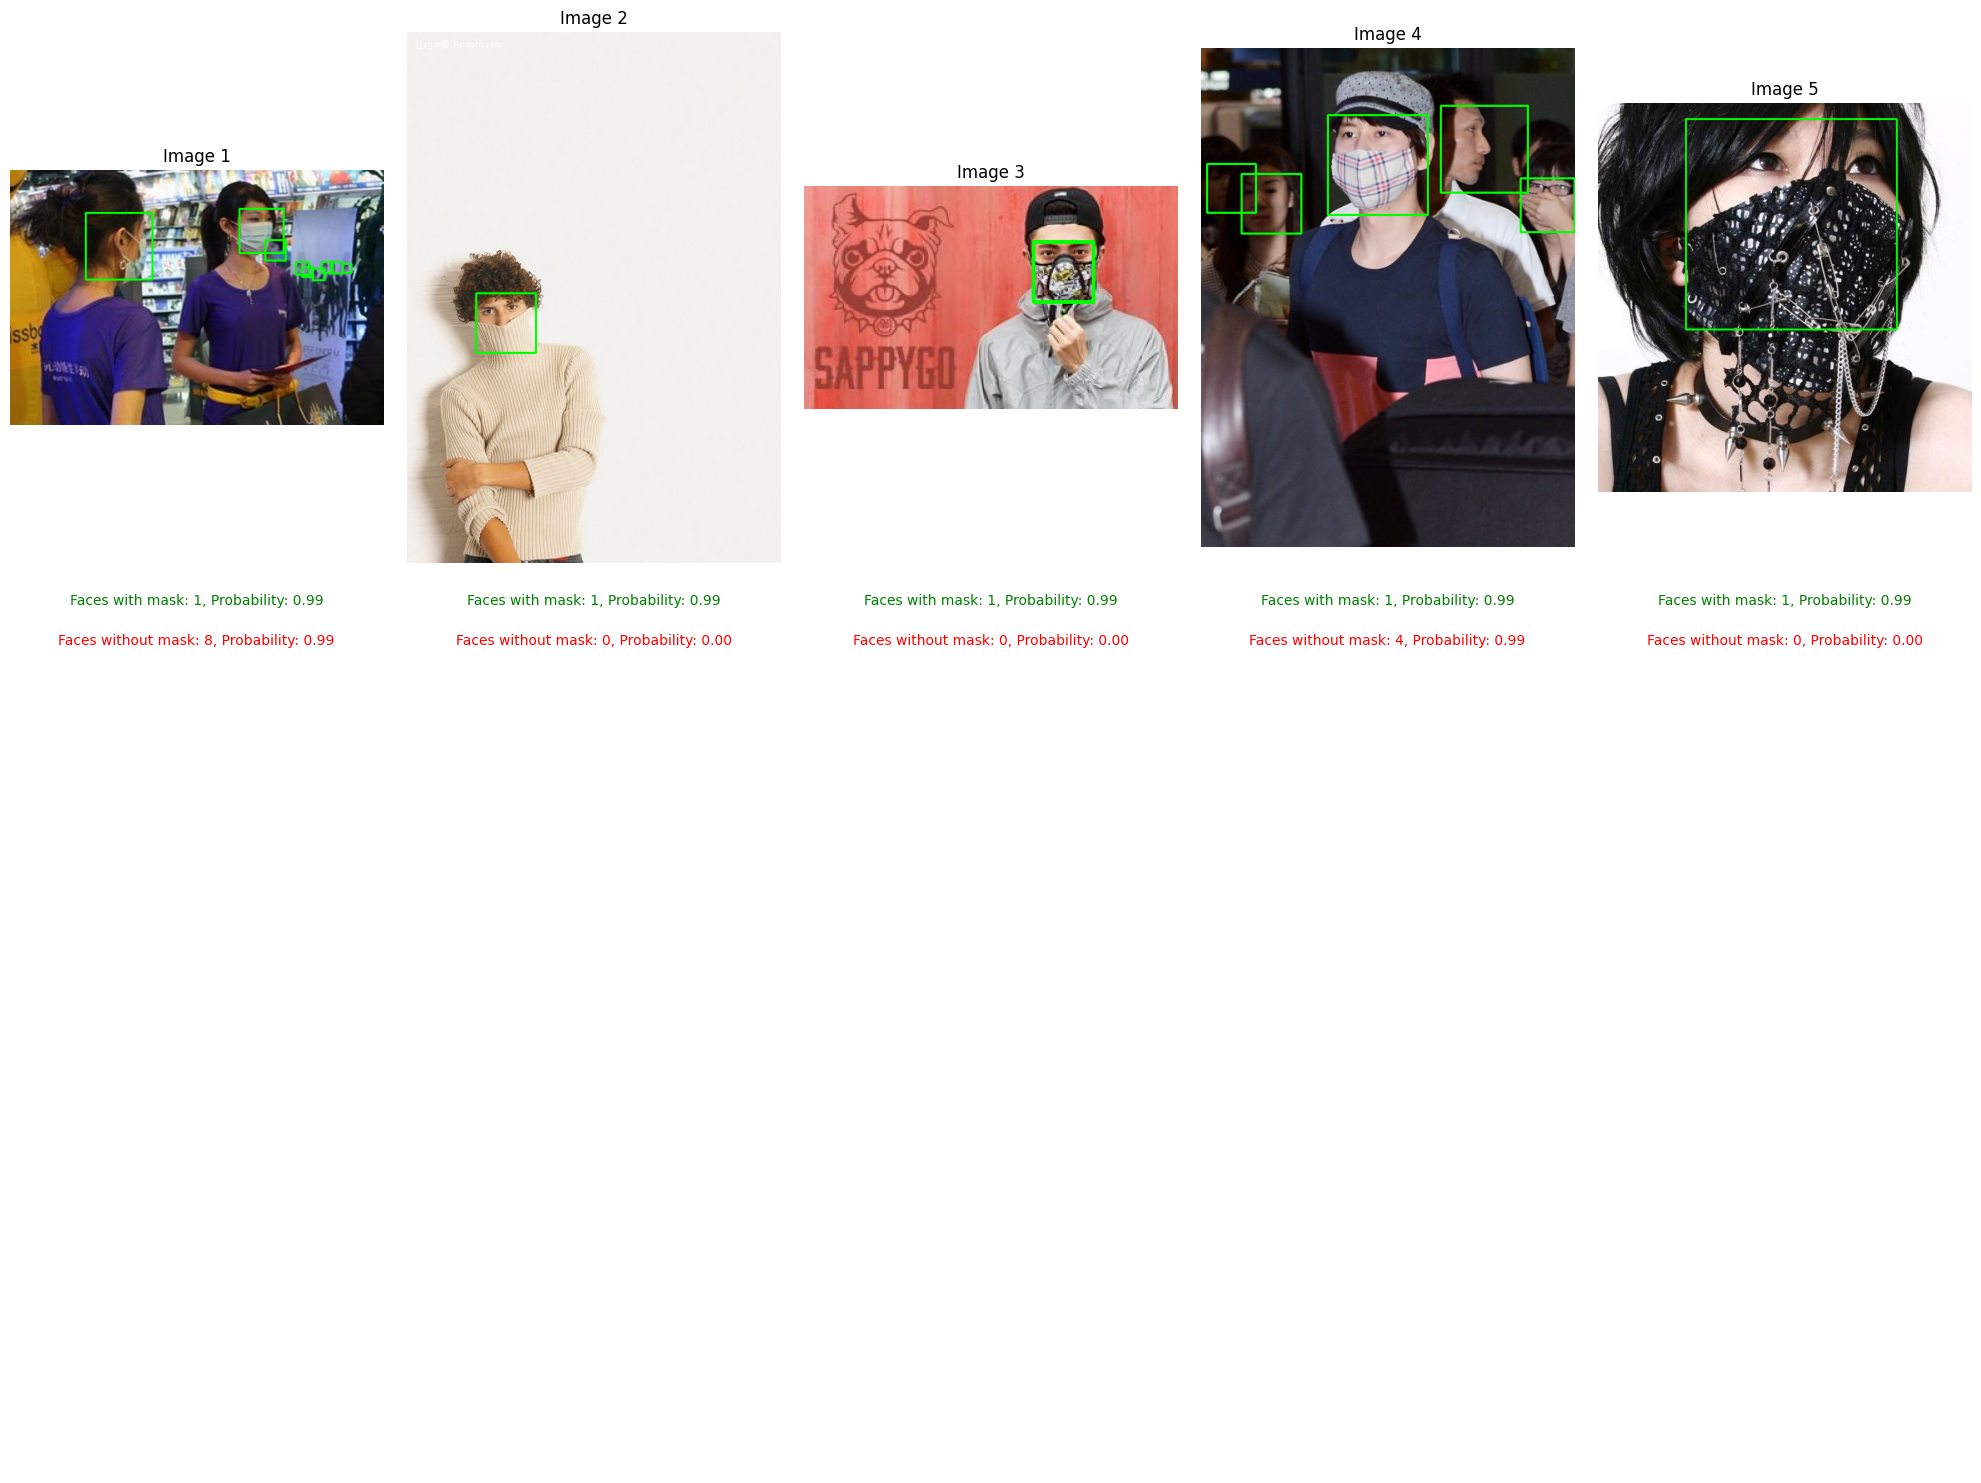

In [19]:
# Model using pretrained CNN EfficientNetB0. Undergoes a total training of 10 epochs. I noticed a convergence in the accuracy, thus further training would not yield better results. Would need to look at further improvement of data i'd imagine.

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Sequential
from keras.utils import to_categorical
import scipy.io as sio
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random

# Load the CSV file
image_labels = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_training_data.csv')
path_to_images = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images"

# Add mask_label column
image_labels['mask_label'] = np.where((image_labels['occluder_type'] == 1) | (image_labels['occluder_type'] == 2), 1, 0)

# Define image size
img_size = 100  # Using a larger image size for better feature extraction

# Load and preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize pixel values
    return img

# Load images and labels
X = np.array([preprocess_image(os.path.join(path_to_images, img_name)) for img_name in image_labels['imgName']])
y = to_categorical(image_labels['mask_label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model's layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model by adding custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 output nodes for binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Load the test data
test_data = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_test_data.csv')
test_images_path = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Test\test-images"

# Display test images with aggregated face mask information
plt.figure(figsize=(20, 16))

for i in range(5):
    selected_row = random.choice(range(len(test_data)))

    row = test_data.iloc[selected_row]
    img_name = row['imgName']
    img_path = os.path.join(test_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Check if there are multiple faces for this image
    faces = test_data[test_data['imgName'] == img_name]
    num_faces_with_mask = 0
    num_faces_without_mask = 0
    combined_mask_probability = 0.0
    combined_no_mask_probability = 0.0

    for _, face_row in faces.iterrows():
        face_x, face_y, face_w, face_h = face_row[['face_x', 'face_y', 'face_w', 'face_h']]
        occluder_type = face_row['occluder_type']

        # Check if the occluder type is a mask
        is_mask = occluder_type == 1 or occluder_type == 2

        # Preprocess the face image
        face_img = img[int(face_y):int(face_y + face_h), int(face_x):int(face_x + face_w)]
        face_img = cv2.resize(face_img, (img_size, img_size))
        face_img = face_img / 255.0  # Normalize pixel values
        face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension

        # Predict using the model
        prediction = model.predict(face_img)
        mask_probability = prediction[0][1]  # Probability of wearing a mask

        if is_mask:
            num_faces_with_mask += 1
            combined_mask_probability += mask_probability
        else:
            num_faces_without_mask += 1
            combined_no_mask_probability += mask_probability

        # Draw a bounding box around the face
        cv2.rectangle(img, (int(face_x), int(face_y)), (int(face_x + face_w), int(face_y + face_h)), (0, 255, 0), 2)

    # Display the image with aggregated face mask information
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

    plt.subplot(2, 5, i+6)
    plt.text(0.5, 1.1, f'Faces with mask: {num_faces_with_mask}, Probability: {combined_mask_probability / num_faces_with_mask if num_faces_with_mask > 0 else 0:.2f}', color='green', fontsize=10, ha='center')
    plt.text(0.5, 1.05, f'Faces without mask: {num_faces_without_mask}, Probability: {combined_no_mask_probability / num_faces_without_mask if num_faces_without_mask > 0 else 0:.2f}', color='red', fontsize=10, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

import logging

# Configure logging
log_filename = r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\logs\EfficientNetB0.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

# Log the evaluation metrics
logging.info(f'Accuracy: {accuracy}')
logging.info(f'Precision: {precision}')
logging.info(f'Recall: {recall}')
logging.info(f'F1 Score: {f1}')

In [10]:
# VGG16 model - Accuracy of 0.936 after 50 cycles

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
from keras.applications import VGG16, VGG19
from keras.optimizers import Adam

# Load the CSV file
image_labels = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_training_data.csv')
path_to_images = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images"

# Add mask_label column
image_labels['mask_label'] = np.where((image_labels['occluder_type'] == 1) | (image_labels['occluder_type'] == 2), 1, 0)

# Define image size
img_size = 100

# Load and preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize pixel values
    return img

X = np.array([preprocess_image(os.path.join(path_to_images, img_name)) for img_name in image_labels['imgName']])
y = to_categorical(image_labels['mask_label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes)
recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Epoch 1/50
369/369 [==============================] - 197s 531ms/step - loss: 0.2322 - accuracy: 0.9258 - val_loss: 0.2031 - val_accuracy: 0.9262
Epoch 2/50
369/369 [==============================] - 184s 499ms/step - loss: 0.2039 - accuracy: 0.9278 - val_loss: 0.1958 - val_accuracy: 0.9292
Epoch 3/50
369/369 [==============================] - 180s 488ms/step - loss: 0.1912 - accuracy: 0.9322 - val_loss: 0.1928 - val_accuracy: 0.9307
Epoch 4/50
369/369 [==============================] - 179s 485ms/step - loss: 0.1859 - accuracy: 0.9334 - val_loss: 0.1901 - val_accuracy: 0.9321
Epoch 5/50
369/369 [==============================] - 179s 486ms/step - loss: 0.1766 - accuracy: 0.9342 - val_loss: 0.1922 - val_accuracy: 0.9329
Epoch 6/50
369/369 [==============================] - 179s 485ms/step - loss: 0.1686 - accuracy: 0.9373 - val_loss: 0.1954 - val_accuracy: 0.9335
Epoch 7/50
369/369 [==============================] - 179s 484ms/step - loss: 0.1634 - accuracy: 0.9388 - val_loss: 0.2065 -

C:\Users\alexw\AppData\Local\Temp\ipykernel_3068\3765477768.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Epoch 1/20



369/369 [==============================] - 241s 649ms/step - loss: 0.2467 - accuracy: 0.9234 - val_loss: 0.2047 - val_accuracy: 0.9240
Epoch 2/20
369/369 [==============================] - 231s 627ms/step - loss: 0.2123 - accuracy: 0.9255 - val_loss: 0.2215 - val_accuracy: 0.9240
Epoch 3/20
369/369 [==============================] - 235s 636ms/step - loss: 0.2075 - accuracy: 0.9256 - val_loss: 0.1962 - val_accuracy: 0.9240
Epoch 4/20
369/369 [==============================] - 240s 650ms/step - loss: 0.1992 - accuracy: 0.9255 - val_loss: 0.1977 - val_accuracy: 0.9240
Epoch 5/20
369/369 [==============================] - 227s 615ms/step - loss: 0.1947 - accuracy: 0.9255 - val_loss: 0.1985 - val_accuracy: 0.9240
Epoch 6/20
369/369 [==============================] - 223s 606ms/step - loss: 0.1932 - accuracy: 0.9255 - val_loss: 0.1984 - val_accuracy: 0.9240
Epoch 7/20
369/369 [==============================] - 219s 594ms/step - loss: 0.1857 - accuracy: 0.9255 - val_loss: 0.1934 - val_accura

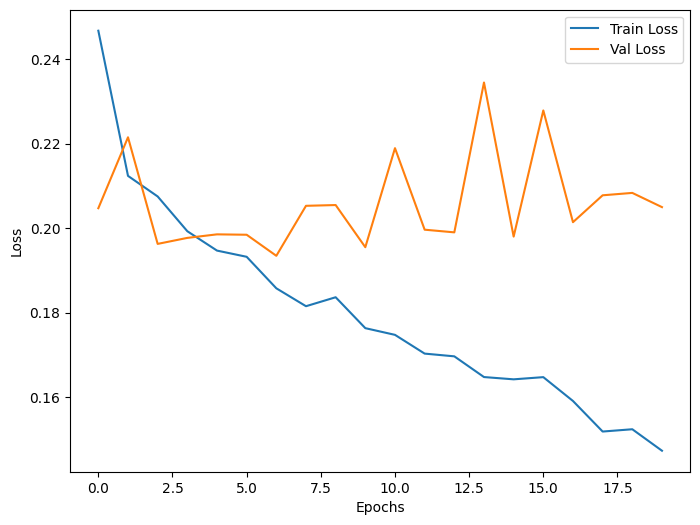

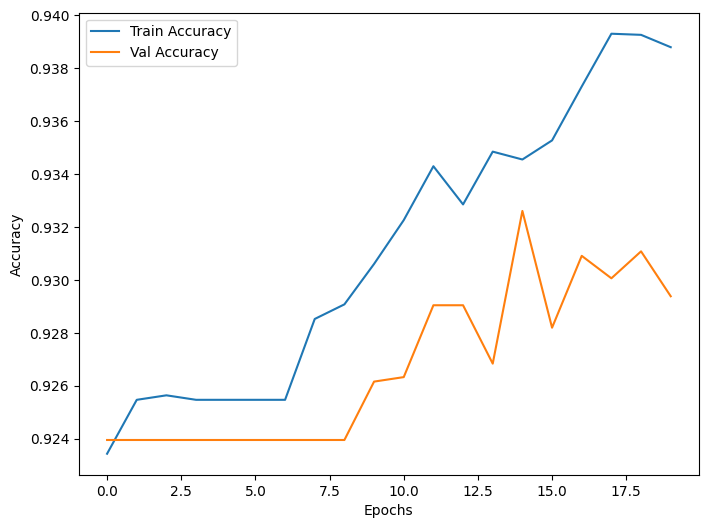

In [1]:
# VGG19 model - Accuracy of 0.934 after 20 cycles

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
from keras.applications import VGG16, VGG19
from keras.optimizers import Adam

# Load the CSV file
image_labels = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_training_data.csv')
path_to_images = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images"

# Add mask_label column
image_labels['mask_label'] = np.where((image_labels['occluder_type'] == 1) | (image_labels['occluder_type'] == 2), 1, 0)

# Define image size
img_size = 100

# Load and preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize pixel values
    return img

X = np.array([preprocess_image(os.path.join(path_to_images, img_name)) for img_name in image_labels['imgName']])
y = to_categorical(image_labels['mask_label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained VGG16 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
model = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_classes)
precision = precision_score(np.argmax(y_test, axis=1), y_pred_classes)
recall = recall_score(np.argmax(y_test, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(y_test, axis=1), y_pred_classes)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

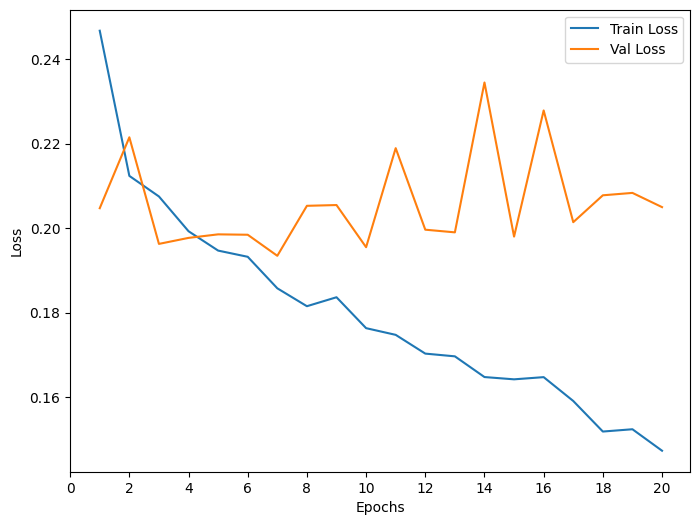

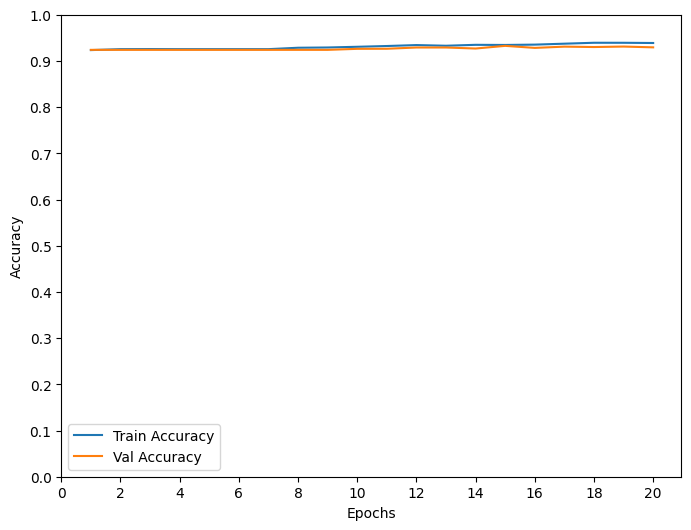

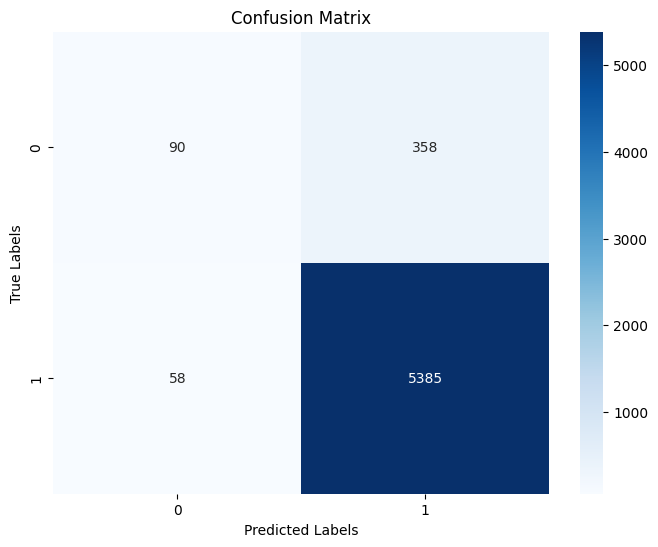

In [11]:
# Plotting training visualisations aswell as confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), history.history['loss'], label='Train Loss')
plt.plot(range(1, 21), history.history['val_loss'], label='Val Loss')
plt.title('')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(range(0, 21, 2))
# plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), history.history['accuracy'], label='Train Accuracy')
plt.plot(range(1, 21), history.history['val_accuracy'], label='Val Accuracy')
plt.title('')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(range(0, 21, 2))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.show()

# Generate confusion matrix
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [20]:
# SVM Model with handcrafted feature extraction.

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the CSV file
train_labels = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_training_data.csv')
train_images = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images"

# Add mask_label column
image_labels['mask_label'] = np.where((image_labels['occluder_type'] == 1) | (image_labels['occluder_type'] == 2), 1, 0)

# Define image size
img_size = 100

# Load and preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    # Extract handcrafted features (e.g., color histograms, texture features)
    features = extract_features(img)
    return features

# Example handcrafted feature extraction function
def extract_features(img):
    # Compute color histograms
    hist_b = cv2.calcHist([img], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([img], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([img], [2], None, [256], [0, 256])

    # Concatenate color histograms into a single feature vector
    features = np.concatenate([hist_b.flatten(), hist_g.flatten(), hist_r.flatten()])

    return features

# Load images and labels
X = np.array([preprocess_image(os.path.join(path_to_images, img_name)) for img_name in image_labels['imgName']])
y = image_labels['mask_label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the SVM model with a limit on the number of iterations
max_iterations = 10000  # Set the maximum number of iterations
svm_model = SVC(kernel='linear', max_iter=max_iterations)
svm_model.fit(X_train, y_train)

# Evaluate the model on test data
y_pred = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# for i in range(5):
#     selected_row = random.choice(range(len(test_data)))

#     row = test_data.iloc[selected_row]
#     img_name = row['imgName']
#     img_path = os.path.join(test_images_path, img_name)
#     img = cv2.imread(img_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#     # Check if there are multiple faces for this image
#     faces = test_data[test_data['imgName'] == img_name]
#     num_faces_with_mask = 0
#     num_faces_without_mask = 0
#     combined_mask_probability = 0.0
#     combined_no_mask_probability = 0.0

#     for _, face_row in faces.iterrows():
#         face_x, face_y, face_w, face_h = face_row[['face_x', 'face_y', 'face_w', 'face_h']]
#         occluder_type = face_row['occluder_type']

#         # Check if the occluder type is a mask
#         is_mask = occluder_type == 1 or occluder_type == 2

#         # Preprocess the face image
#         face_img = img[int(face_y):int(face_y + face_h), int(face_x):int(face_x + face_w)]
#         face_img = cv2.resize(face_img, (img_size, img_size))
#         face_img = face_img / 255.0  # Normalize pixel values
#         face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension

#         # Predict using the model
#         prediction = svm_model.predict(face_img)
#         mask_probability = prediction[0][1]  # Probability of wearing a mask

#         if is_mask:
#             num_faces_with_mask += 1
#             combined_mask_probability += mask_probability
#         else:
#             num_faces_without_mask += 1
#             combined_no_mask_probability += mask_probability

#         # Draw a bounding box around the face
#         cv2.rectangle(img, (int(face_x), int(face_y)), (int(face_x + face_w), int(face_y + face_h)), (0, 255, 0), 2)

#     # Display the image with aggregated face mask information
#     plt.subplot(2, 5, i+1)
#     plt.imshow(img)
#     plt.axis('off')
#     plt.title(f'Image {i+1}')

#     plt.subplot(2, 5, i+6)
#     plt.text(0.5, 1.1, f'Faces with mask: {num_faces_with_mask}, Probability: {combined_mask_probability / num_faces_with_mask if num_faces_with_mask > 0 else 0:.2f}', color='green', fontsize=10, ha='center')
#     plt.text(0.5, 1.05, f'Faces without mask: {num_faces_without_mask}, Probability: {combined_no_mask_probability / num_faces_without_mask if num_faces_without_mask > 0 else 0:.2f}', color='red', fontsize=10, ha='center')
#     plt.axis('off')

# plt.tight_layout()
# plt.show()

C:\Users\alexw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.866576133084366
Precision: 0.9240575487160808
Recall: 0.9322065037663053
F1 Score: 0.928114139381745


In [22]:
# SVM + EfficientNetB0 Hybrid Model

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from keras.applications import EfficientNetB0
from keras.models import Model
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the CSV file
image_labels = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_training_data.csv')
path_to_images = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images"

# Add mask_label column
image_labels['mask_label'] = np.where((image_labels['occluder_type'] == 1) | (image_labels['occluder_type'] == 2), 1, 0)

# Define image size
img_size = 100  # Using a larger image size for better feature extraction

# Load and preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize pixel values
    return img

# Load images and labels
X = np.array([preprocess_image(os.path.join(path_to_images, img_name)) for img_name in image_labels['imgName']])
y = image_labels['mask_label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the pre-trained EfficientNetB0 model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

# Create a new model by removing the last classification layer
feature_extractor = Model(inputs=base_model.input, outputs=base_model.output)

# Freeze the base model's layers
for layer in feature_extractor.layers:
    layer.trainable = False

# Extract features from the training data
X_train_features = feature_extractor.predict(X_train)
X_train_features = X_train_features.reshape(X_train_features.shape[0], -1)

# Extract features from the test data
X_test_features = feature_extractor.predict(X_test)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Train the SVM model with the extracted features
svm_model = SVC(kernel='linear', max_iter=1000)
svm_model.fit(X_train_features, y_train)

# Evaluate the hybrid model on test data
y_pred = svm_model.predict(X_test_features)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

185/185 [==============================] - 13s 69ms/step


C:\Users\alexw\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 0.920726531997963
Precision: 0.9238500851788757
Recall: 0.9963255557596914
F1 Score: 0.9587200565720853


C:\Users\alexw\AppData\Local\Temp\ipykernel_2652\2899022659.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd





Epoch 1/50


369/369 [==============================] - 65s 168ms/step - loss: 0.3653 - accuracy: 0.9151 - val_loss: 1.0953 - val_accuracy: 0.1338 - lr: 1.0000e-04
Epoch 2/50
369/369 [==============================] - 61s 164ms/step - loss: 0.3088 - accuracy: 0.9250 - val_loss: 0.4324 - val_accuracy: 0.9134 - lr: 1.0000e-04
Epoch 3/50
369/369 [==============================] - 61s 165ms/step - loss: 0.3000 - accuracy: 0.9251 - val_loss: 0.6579 - val_accuracy: 0.8034 - lr: 1.0000e-04
Epoch 4/50
369/369 [==============================] - 60s 163ms/step - loss: 0.2970 - accuracy: 0.9254 - val_loss: 0.5323 - val_accuracy: 0.9044 - lr: 1.0000e-04
Epoch 5/50
369/369 [==============================] - 60s 162ms/step - loss: 0.2966 - accuracy: 0.9253 - val_loss: 0.6099 - val_accuracy: 0.8983 - lr: 1.0000e-04
Epoch 6/50
369/369 [==============================] - 60s 162ms/step - loss: 0.2957 - accuracy: 0.9254 - val_loss: 0.6468 - val_accuracy: 0.8873 - lr: 1.0000e-04
Epoch 7/50
185/185 [===

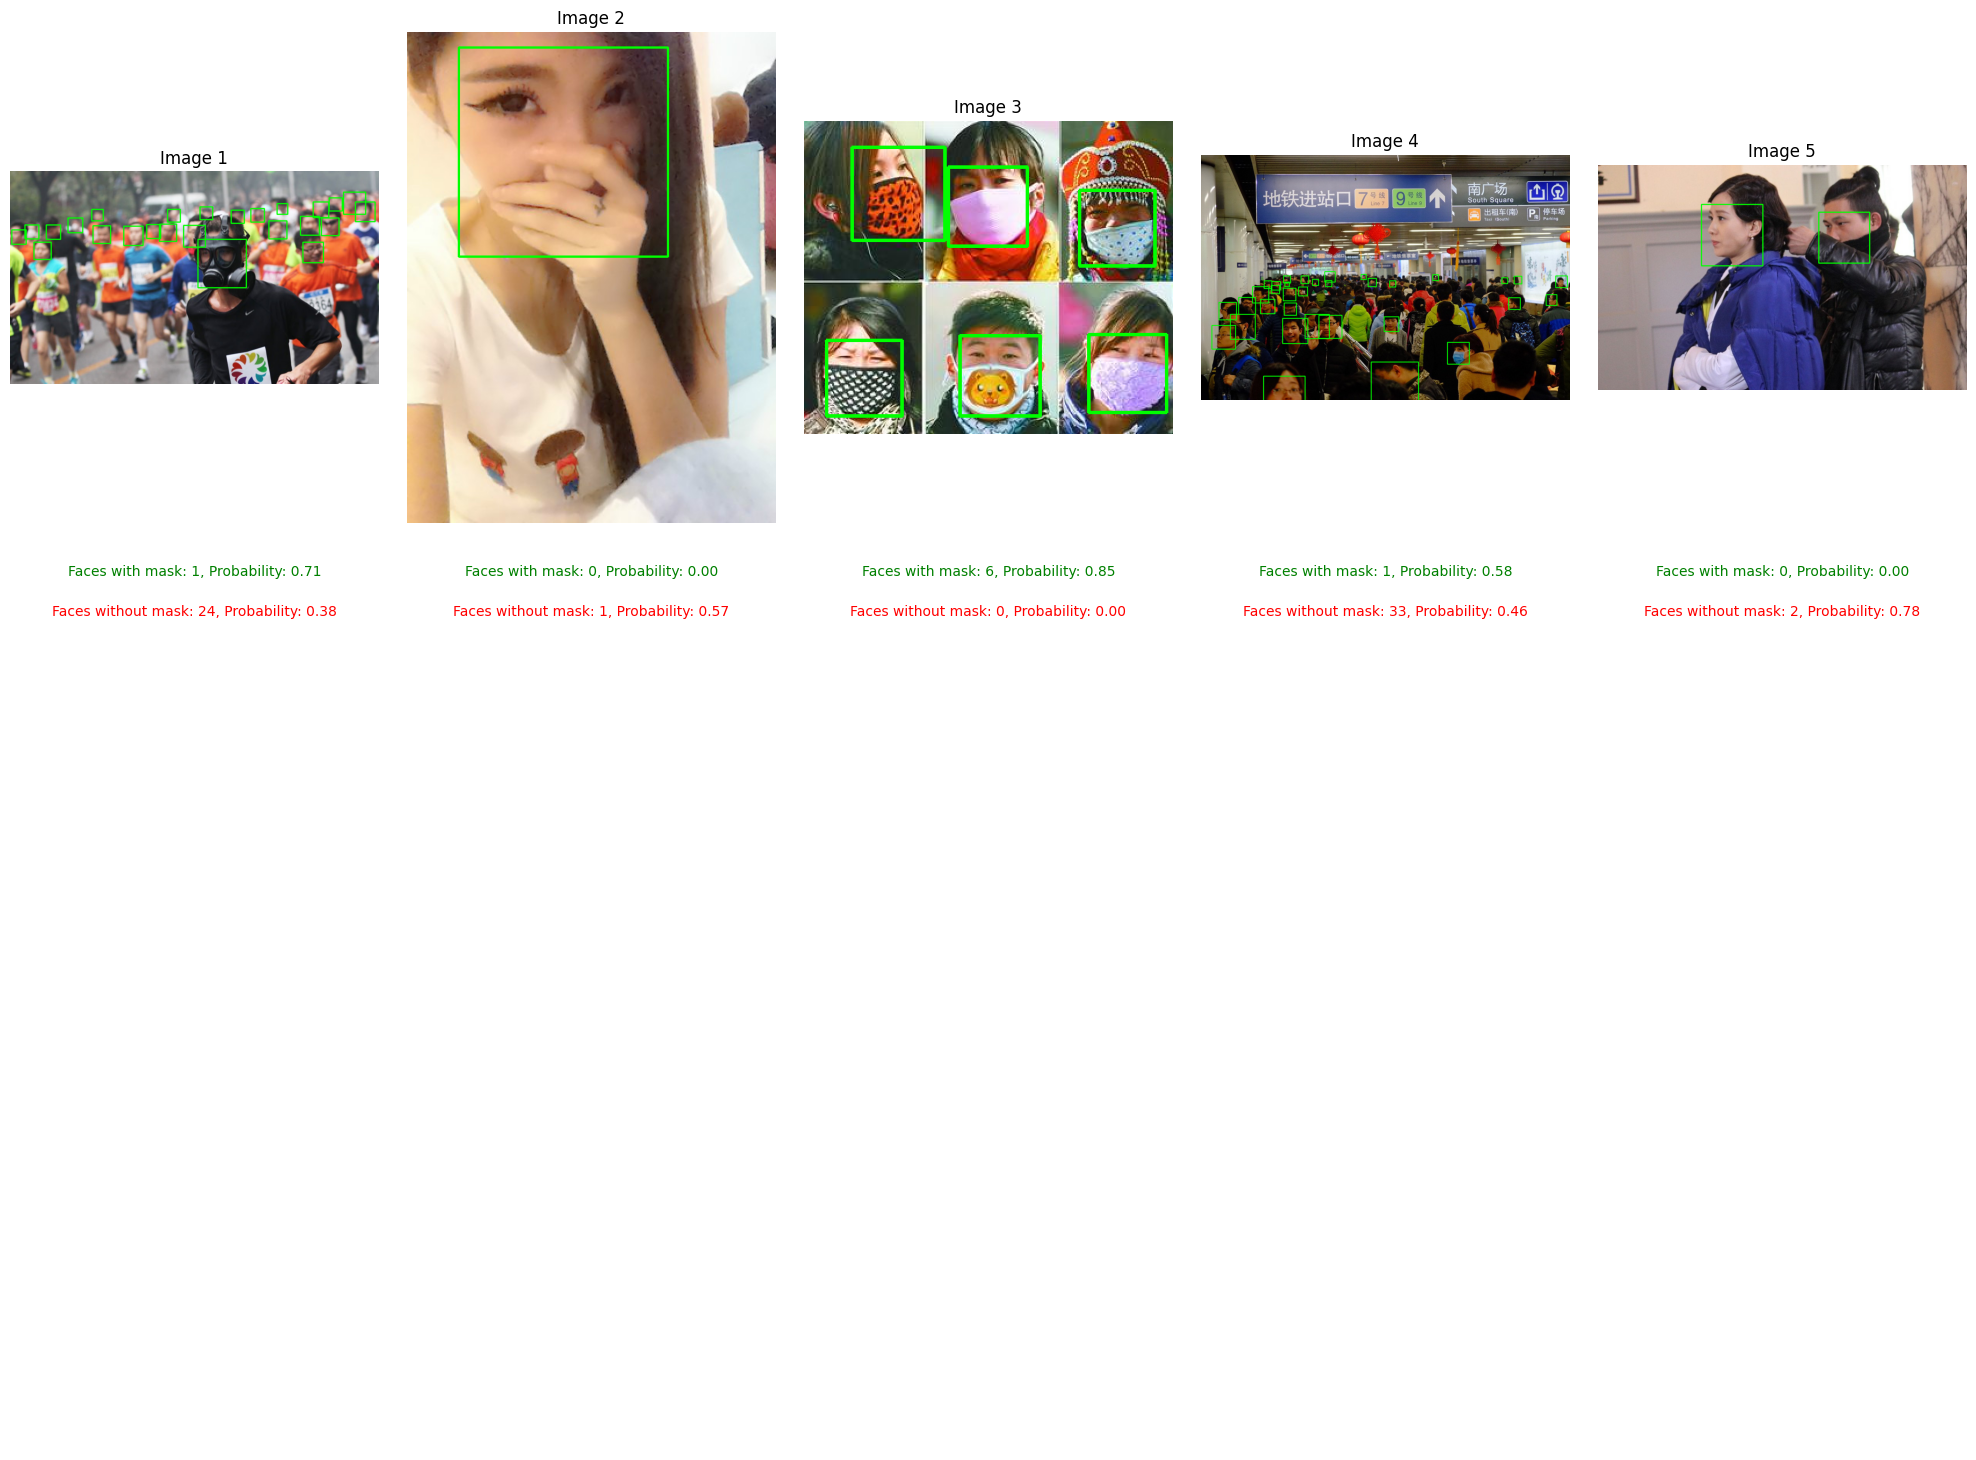

In [1]:
# CNN overfitting test...Trains properly with an accuracy score of 0.9255 and takes 18 epochs before early exit...

import pandas as pd
import numpy as np
import cv2
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import random
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping

# Load the CSV file
image_labels = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_training_data.csv')
path_to_images = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Train\train-images"

# Add mask_label column
image_labels['mask_label'] = np.where((image_labels['occluder_type'] == 1) | (image_labels['occluder_type'] == 2), 1, 0)

# Define image size
img_size = 100

# Load and preprocess images
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0  # Normalize pixel values
    return img

X = np.array([preprocess_image(os.path.join(path_to_images, img_name)) for img_name in image_labels['imgName']])
y = to_categorical(image_labels['mask_label'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define image augmentation parameters
def random_angle():
    return np.random.uniform(0, 360)  # Random angle between 0 and 360 degrees

def random_percentage():
    return np.random.uniform(0, 1)  # Random percentage between 0 and 1

def random_choice():
    return np.random.choice([True, False])  # Random boolean value

# Define image augmentation parameters with more aggressive augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

# Create augmented data generator  
augmented_datagen = datagen.flow(X_train, y_train, batch_size=64)

from keras.layers import BatchNormalization
from keras.callbacks import LearningRateScheduler

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95

# Create a learning rate scheduler callback
lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Further Simplified Model with More Regularization and Batch Normalization
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model with reduced learning rate
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model with early stopping and validation monitoring
history = model.fit(augmented_datagen, epochs=50, validation_data=(X_test, y_test), callbacks=[early_stopping, lr_scheduler_callback])

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

# Evaluate the model on test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes)
recall = recall_score(y_test_classes, y_pred_classes)
f1 = f1_score(y_test_classes, y_pred_classes)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Load the test data
test_data = pd.read_csv(r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\csv\MAFA_test_data.csv')
test_images_path = r"C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Datasets\MAFA\MAFA-Label-Test\test-images"

# Display test images with aggregated face mask information
plt.figure(figsize=(20, 16))

for i in range(5):
    selected_row = random.choice(range(len(test_data)))

    row = test_data.iloc[selected_row]
    img_name = row['imgName']
    img_path = os.path.join(test_images_path, img_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Check if there are multiple faces for this image
    faces = test_data[test_data['imgName'] == img_name]
    num_faces_with_mask = 0
    num_faces_without_mask = 0
    combined_mask_probability = 0.0
    combined_no_mask_probability = 0.0

    for _, face_row in faces.iterrows():
        face_x, face_y, face_w, face_h = face_row[['face_x', 'face_y', 'face_w', 'face_h']]
        occluder_type = face_row['occluder_type']

        # Check if the occluder type is a mask
        is_mask = occluder_type == 1 or occluder_type == 2

        # Preprocess the face image
        face_img = img[int(face_y):int(face_y + face_h), int(face_x):int(face_x + face_w)]
        face_img = cv2.resize(face_img, (img_size, img_size))
        face_img = face_img / 255.0  # Normalize pixel values
        face_img = np.expand_dims(face_img, axis=0)  # Add batch dimension

        # Predict using the model
        prediction = model.predict(face_img)
        mask_probability = prediction[0][1]  # Probability of wearing a mask

        if is_mask:
            num_faces_with_mask += 1
            combined_mask_probability += mask_probability
        else:
            num_faces_without_mask += 1
            combined_no_mask_probability += mask_probability

        # Draw a bounding box around the face
        cv2.rectangle(img, (int(face_x), int(face_y)), (int(face_x + face_w), int(face_y + face_h)), (0, 255, 0), 2)

    # Display the image with aggregated face mask information
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Image {i+1}')

    plt.subplot(2, 5, i+6)
    plt.text(0.5, 1.1, f'Faces with mask: {num_faces_with_mask}, Probability: {combined_mask_probability / num_faces_with_mask if num_faces_with_mask > 0 else 0:.2f}', color='green', fontsize=10, ha='center')
    plt.text(0.5, 1.05, f'Faces without mask: {num_faces_without_mask}, Probability: {combined_no_mask_probability / num_faces_without_mask if num_faces_without_mask > 0 else 0:.2f}', color='red', fontsize=10, ha='center')
    plt.axis('off')

plt.tight_layout()
plt.show()

import logging

# Configure logging
log_filename = r'C:\Users\alexw\OneDrive\Documents\03_Education\University_Programming\Python\Big_Data\Coursework\Masked_Face\logs\CNN.log'
logging.basicConfig(filename=log_filename, level=logging.INFO, format='%(asctime)s - %(message)s', datefmt='%d-%b-%y %H:%M:%S')

# Log the evaluation metrics
logging.info(f'Accuracy: {accuracy}')
logging.info(f'Precision: {precision}')
logging.info(f'Recall: {recall}')
logging.info(f'F1 Score: {f1}')